### V4 Neural Data Challenge

#### Motivation
Understanding how the brain gives rise to intelligence is undeniably one of the greatest challenges facing scientists today. One aspect of this intelligence is how the brain encodes sensory inputs (e.g. patterns of light which reach the eye) into a useful representation (e.g. objects with properties like a category). 

#### Background
These data come from the Pasupathy lab in the department of biological structure recorded by the very talented electrophysiologist Polina Zamarashkina. Their lab is a primate electrophysiology lab studying how visual input is processed by the brain. They study how single neurons support primates' rich representation of the visual world. Neurons are specialized cells which generate rapid changes in voltage across their membrane called spikes which cause the release of neurotransmitter onto other neurons which increase or decrease the likelihood that other neurons produce spikes. The lab tries to understand the relationship between the images a monkey is observing and the likelihood of a neuron generating a spike in response to that image. They focus on understanding the neurons in the visual ventral stream a series of regions in the brain which is thought to be integral in the processing of the category of visual objects. For example there are neurons in the ventral stream which respond selectivley to faces  Their main focus is on an area of the brain called 'V4'. This area is an intermediate area in the ventral stream, earlier areas seem to represent quite simple visual properties such as edges and late areas represent more abstract categories like faces, whereas V4 is thought to be an intermediate representation transforming the simpler features in earlier areas into . Their strategy to understand this area is to place electrodes in the brain and carefully record the number of spikes a neuron produces in response to images and then to build models which predict the number of spikes given an image.

### Data
These data were collected by placing an electrode into visual area V4 in an awake Macaque and recording the number of spikes as up to 601 images were shown with between 3-20 repeats for each images. These images were drawn semi-randomly from the 2012 ILSVRC validation set of images where a 80X80 pixel patch was sampled then had  soft window applied (circular alpha gaussian with standard deviation 16 pixels). 

There are two basic categories of recordings: multiunit where the number of spikes from a small population of neurons is recorded and single unit where through careful post-processing it was insured the number of spikes recorded were from a single neuron. Images were shown for 300 ms with 250 ms in between images, the data you will examine is the average number of spikes between 50 and 350 ms after the image appeared. We chose 10 of the units with the best tuning i.e. did in fact change their spike rate across different images in a reliable manner.

You will be provided with all images but only a subset of their associated responses, your goal will be to predict the responses to the images for which you do not have the associated responses. The quality of your predictions will be based on how well your predictions correlate to the square root of the observed responses.


#### Getting started
Below I will load in the dataset and create a very simple model and test its performance using cross-validation to attempt to predict its performance on the test set.

In [46]:
#load the train data with popular tool pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

#load the stimuli with numpy
stim = np.load('stim.npy')
df = pd.read_csv('train.csv')
df.index = df.stim
df = df.iloc[:,1:]
print(df.shape)
df.head()

(551, 18)


,10_1_2018_0_0,10_1_2018_0_1,11_06_18_0_0,11_06_18_0_1,11_07_18_0_0,11_07_18_1_0,11_08_18_0_0,11_08_18_0_1,11_09_18_0_1,9_17_2018_0_0,9_17_2018_0_1,9_20_2018_0_0,9_21_2018_0_0,9_21_2018_0_1,9_26_2018_0_0,9_26_2018_0_1,9_28_2018_0_0,9_28_2018_0_1
stim,,,,,,,,,,,,,,,,,,
50,6.782330,1.414214,5.622356,1.172872,3.835296,9.107331,2.928577,1.002235,0.900420,6.174053,0.500000,3.813243,2.146952,1.668328,1.976085,0.788675,6.557439,1.414214
51,8.124038,1.000000,6.561819,0.477671,2.642316,6.778426,4.691500,0.596407,1.675685,6.269141,0.333333,3.589276,2.924137,2.961930,1.932416,0.166667,6.000000,0.000000
52,8.544004,0.000000,6.707088,0.892229,1.457884,4.877056,3.632468,1.812880,0.728759,6.771823,0.804738,4.632351,2.833196,1.696923,2.354642,0.955342,4.000000,0.000000
53,8.062258,2.000000,6.980861,0.699075,4.991866,9.280055,5.040368,0.181818,2.019465,6.531085,0.166667,4.502757,2.995157,1.199359,3.094110,2.474990,8.944272,0.000000
54,8.306624,1.414214,5.663736,0.284518,3.183899,8.674227,5.017551,0.272727,1.197206,6.007232,0.166667,3.573848,2.647334,1.646386,1.009994,1.288675,6.403124,0.000000


So here is the average number of spikes for the different recordings between 50-350 ms after the presentation of image 50 through 650. Stim number is in the second to left column, in the the first row are the labels for each cell. The first three numbers are the date of the recording, the next is the recording session number in a day, and the final number is 0 if it was a multiunit recording and 1 if it was a single unit. You will notice the multunit will have higher numbers of spikes than the single unit.

The important things to note are: the stim number starts at 50 so you only have the responses to images with indexes 50 and above and some cells were shown fewer images than others and their values are filled in with nans.

Now lets look at the stimuli

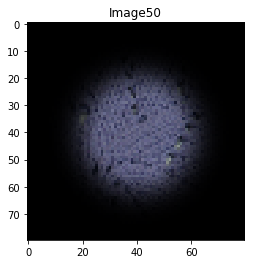

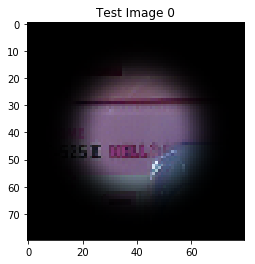

In [47]:
a_train_ind = 50
plt.imshow(stim[a_train_ind]);
plt.title('Image' + str(a_train_ind));
plt.figure();
a_test_ind = 0
plt.imshow(stim[a_test_ind]);
plt.title('Test Image ' + str(a_test_ind));


The first image is stim 50, which is from the training data, and so we know the spike number. So for example the single unit recorded on 10/1/2018 (2nd column in table above) had on average 1.5 spikes in response to this image. The ability of your algorithm to predict the responses to images 0-49 will determine your performance in the competition.

To get you started and help you understand how to submit your results I will make a simple model below and submit its results. My hypothesis will be that all neurons are generally responding to the average color in the image. So I will take each image calculate the total amount of red, green, and blue then find the coefficients that best predict the respons of the neuron on the basis these three features. Quantitatively my hypothesis will be that the number of spikes is a linear combination of the amount of red green and blue in an image.

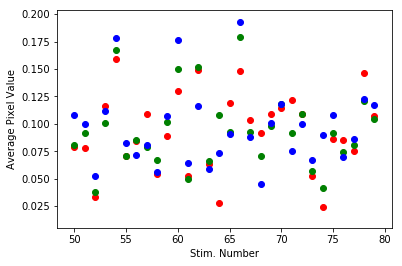

In [48]:
rgb = np.mean(stim, (1,2))#average RGB across rows and columns of each image
for i, c in enumerate(rgb.T):
    plt.scatter(range(len(c))[50:80], c[50:80], color=['r','g','b'][i], alpha=1);
plt.ylabel('Average Pixel Value');plt.xlabel('Stim. Number')

Just looking at the test a sample of the average RGB values for the images we can see some  have similar amounts of red green and blue (all points near each other) on different. Now lets take the RGB averagevalues from the training images and regress them on spike number.

In [ ]:
rec = df.iloc[:, 6].dropna()#use the command dropna as this cell only was shown 0-200 images
rec.plot();
plt.xlabel('Stim Number');plt.ylabel('Avg. Sqrt. # Spikes');
plt.title(rec.name)

The cell clearly responded with more spikes to some images than it did to others, lets see if we can get an intuition for what evoked a large number of spikes by looking at the images which evoked the greatest average number of spikes:

Lets look at the images the cell preferred the most:

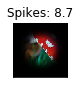

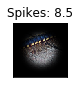

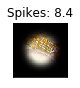

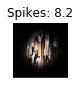

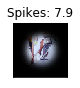

In [23]:
top_n = 5
best_resp_inds = rec.argsort()[::-1].values
for ind in best_resp_inds[:top_n]:
    plt.figure(figsize=(1,1))
    plt.imshow(stim[50:][ind]/np.max(stim[50:][ind]));
    plt.xticks([]);plt.yticks([])
    plt.title('Spikes: ' + str(np.round(rec.iloc[ind],1)))


What would you guess the cell prefers? How would you perform a computation on these images which approximated that intuition?

In [24]:
rec = df.iloc[:, 6].dropna()
x = rgb[50:][:len(rec)]
y = rec.values
A = np.hstack([x, np.ones((len(y), 1))])
coefs = np.linalg.lstsq(A, y)[0];
fit_y = np.dot(A, coefs)

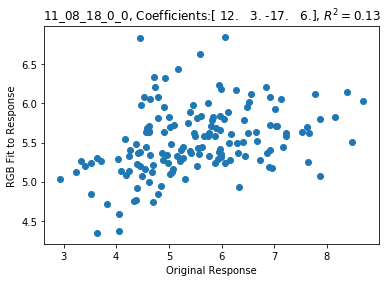

In [25]:
plt.scatter(y, fit_y);
r = np.corrcoef(fit_y, y)[0,1]**2
plt.title(rec.name + ', Coefficients:' + str(np.round(coefs)) + 
          r', $R^2=$' + str(round(r,2)));
plt.xlabel('Original Response')
plt.ylabel('RGB Fit to Response')

So we account for a little over 10% of the variance using a very simple feature for the population recorded from on November 8th. The coefficient on red was 12 so when there was alot of red the cell tended respond the most, coefficient on green was 3 so green was associated with higher responses as well, whereas when blue was present the cell tended to fire very little on average. Can you think of other features you can extract from the image that might better predict responses?

Now lets organize all of our responses for a submission. The submission will be a matrix which has 50 rows for each of the held out respones and a column for each individual recording. 

In [35]:
test_preds = [] # create list to contain predictions
trainr2 = [] # list for fit to training data
A = np.hstack([rgb, np.ones((rgb.shape[0], 1))]) #linear predictors rgb, and constant(intercept)
for i in range(df.shape[1]):#for each recording
    rec = df.iloc[:, i].dropna()#get recording drop nan responses
    y = rec.values # load responses into numpy array
    A_train = A[50:][:len(rec)]#get features of images we have responses for
    A_test = A[:50]#get features for test images you are making prediction on
    #train model i.e. regress rgb values onto responses
    coefs = np.linalg.lstsq(A_train, y)[0];
    fit_train_y = np.dot(A_train, coefs)#get the prediction for known responses
    trainr2.append(np.corrcoef(y,fit_train_y)[0,1])
    fit_test_y = np.dot(A_test, coefs)
    test_preds.append(fit_test_y)

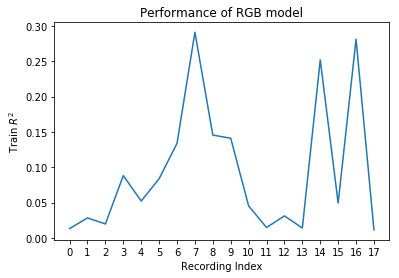

In [45]:
test_preds = np.array(test_preds).T
trainr2= np.array(trainr2)
test_preds.shape
plt.figure()
plt.plot(trainr2**2);plt.xlabel('Recording Index');plt.ylabel(r'Train $R^2$')
plt.xticks(range(len(trainr2)));plt.title('Performance of RGB model');

From the plot above it is clear some of the cells are actually pretty well predicted by the average RGB values (7,14,16) with almost a quarter of the variance accounted for. Now to submit your predictions you can save them to the working directory then download from that working directory. 

In [ ]:
np.save('submission.npy', test_preds)

Now the final step is to submit your results. The above line of code should have saved a numpy file called, 'submission.npy' to the working directory. Now download it and attach it to an email addressed to 'uwndc19@gmail.com' in the subject line put: 'uwndc_sub_<yourteamnamehere>'. Pretty soon we will start automatically replying to these emails with your performance on the test set.

Feel free to try explore the data using this binder notebook but also feel free to download it and the data to run on your own computer. Good luck and if you have any questions feel free to email 'uwndc19@gmail.com' and will try to get back to you ASAP.